# Single time step prediction
## — with single input 

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
import lightning as L

from darts.datasets import EnergyDataset
from darts.dataprocessing.transformers import MissingValuesFiller
import numpy as np

from ontime.module import preprocessing

---
## Load data

In [93]:
energy_ts = EnergyDataset().load()
energy_ts = energy_ts.astype(np.float32)
single_ts = energy_ts.univariate_component(0)

---
## Preprocessing

In [94]:
# Fill missing values
transformer = MissingValuesFiller()
single_ts = transformer.transform(single_ts)

# Normalize
single_ts = preprocessing.common.normalize(single_ts)

# Train test split
train, test = preprocessing.common.train_test_split(single_ts, train_split=0.8)

# Split in vectors of length n
train_list = preprocessing.common.split_by_length(train, length=2, shift=2)
test_list = preprocessing.common.split_by_length(test, length=2, shift=2)

# Split each vector in input and target
X_train, y_train = preprocessing.common.split_inputs_from_targets(train_list, input_length=1, target_length=1)
X_test, y_test = preprocessing.common.split_inputs_from_targets(test_list, input_length=1, target_length=1)

# Convert to Numpy
X_train = preprocessing.common.timeseries_list_to_numpy(X_train)
y_train = preprocessing.common.timeseries_list_to_numpy(y_train)
X_test = preprocessing.common.timeseries_list_to_numpy(X_test)
y_test = preprocessing.common.timeseries_list_to_numpy(y_test)

In [95]:
print(type(X_train))
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
(14025, 1, 1)
(3506, 1, 1)
(3506, 1, 1)


---
## Modelling

In [96]:
input_shape = X_train[0].shape
output_shape = y_train[0].shape

In [97]:
model = nn.Sequential(
    nn.Linear(1, 1),
    nn.ReLU()
)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Convert X_train and y_train to PyTorch tensors if not already
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)


In [98]:
num_epochs = 5000
# Training loop
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights

    # Print the loss every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/5000], Loss: 0.0006
Epoch [1000/5000], Loss: 0.0006
Epoch [1500/5000], Loss: 0.0005
Epoch [2000/5000], Loss: 0.0005
Epoch [2500/5000], Loss: 0.0005
Epoch [3000/5000], Loss: 0.0005
Epoch [3500/5000], Loss: 0.0005
Epoch [4000/5000], Loss: 0.0005
Epoch [4500/5000], Loss: 0.0005
Epoch [5000/5000], Loss: 0.0005


### Evaluate 

In [99]:

# Convert X_val and y_val to PyTorch tensors if not already
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Set the model to evaluation mode
model.eval()

# Forward pass on the validation set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f'Validation Loss: {test_loss.item():.4f}')


Validation Loss: 0.0003


---
## Predict

In [100]:
# Forward pass on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# Convert the tensor results back to a NumPy array
predicted_values = test_outputs.numpy()

predicted_values

array([[[0.42659786]],

       [[0.43494588]],

       [[0.42158908]],

       ...,

       [[0.5050693 ]],

       [[0.50339967]],

       [[0.49505165]]], dtype=float32)

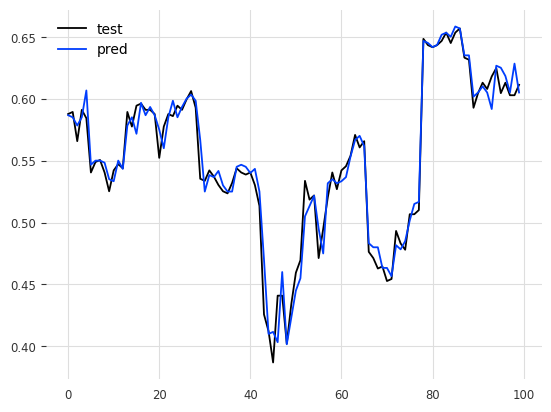

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

start = 500
width = 100

fig, ax = plt.subplots()
pd.DataFrame(y_test.squeeze()[start:start + width]).plot(ax=ax)
pd.DataFrame(predicted_values.squeeze()[start:start + width]).plot(ax=ax)
ax.legend(['test', 'pred']);